In [1]:
!pip install pyLDAvis
import nltk
nltk.download('punkt')
from nltk import sent_tokenize,word_tokenize
from nltk import regexp_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet


import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline


nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
month = ['jan','feb','march','april','may']
year = ['2017','2018']

In [4]:
df_list = []
for i in year:
  for j in month:
    if i == '2018' and j == 'May':
      break
    str1 = 'article_'+j+'_'+i
    df_list.append(str1)

In [5]:
for i in df_list:
  print(i)

article_jan_2017
article_feb_2017
article_march_2017
article_april_2017
article_may_2017
article_jan_2018
article_feb_2018
article_march_2018
article_april_2018
article_may_2018


In [6]:
def update_df(df,month,year):
  str1 = '/content/drive/MyDrive/NYT COMMENTS/'+df
  print(str1)
  df = pd.read_csv(str1)
  df['Month'] = pd.Series([month for x in range(len(df.index))])
  df['Year'] = pd.Series([year for x in range(len(df.index))])
  return df

In [7]:
article_jan_2017 = update_df('ArticlesJan2017.csv','Jan','2017')
article_feb_2017 = update_df('ArticlesFeb2017.csv','Feb','2017')
article_march_2017 = update_df('ArticlesMarch2017.csv','March','2017')
article_april_2017 = update_df('ArticlesApril2017.csv','April','2017')
article_may_2017 = update_df('ArticlesMay2017.csv','May','2017')
article_jan_2018 = update_df('ArticlesJan2018.csv','Jan','2018')
article_feb_2018 = update_df('ArticlesFeb2018.csv','Feb','2018')
article_march_2018 = update_df('ArticlesMarch2018.csv','March','2018')
article_april_2018 = update_df('ArticlesApril2018.csv','April','2018')

frames = [article_jan_2017,article_feb_2017,article_march_2017,article_april_2017,article_may_2017,
          article_jan_2018,article_feb_2018,article_march_2018,article_april_2018]
article_df = pd.concat(frames)


/content/drive/MyDrive/NYT COMMENTS/ArticlesJan2017.csv
/content/drive/MyDrive/NYT COMMENTS/ArticlesFeb2017.csv
/content/drive/MyDrive/NYT COMMENTS/ArticlesMarch2017.csv
/content/drive/MyDrive/NYT COMMENTS/ArticlesApril2017.csv
/content/drive/MyDrive/NYT COMMENTS/ArticlesMay2017.csv
/content/drive/MyDrive/NYT COMMENTS/ArticlesJan2018.csv
/content/drive/MyDrive/NYT COMMENTS/ArticlesFeb2018.csv
/content/drive/MyDrive/NYT COMMENTS/ArticlesMarch2018.csv
/content/drive/MyDrive/NYT COMMENTS/ArticlesApril2018.csv


In [8]:
# article_df = pd.read_csv('/content/drive/MyDrive/NYT COMMENTS/ArticlesApril2017.csv')

In [9]:
article_df['Month'].value_counts()
len(article_df)

9335

In [10]:
import re
import string

def dataframe_clean(text):
   
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

abc = lambda x: dataframe_clean(x)

article_data_clean_headline = pd.DataFrame(article_df['headline'].apply(abc))
article_data_clean_snippet = pd.DataFrame(article_df['snippet'].apply(abc))
article = pd.concat([article_data_clean_headline, article_data_clean_snippet], axis=1)

In [11]:
article.head()

headline                                            snippet
0     gop leadership poised to topple obamas pillars  the most powerful and ambitious republicanled ...
1  fractured world tested the hope of a young pre...  a strategy that went from a good war to the sh...
2                               little troublemakers             chuck deodene puts us in a bubbly mood
3                  angela merkel russias next target  with a friend entering the white house vladimi...
4                      boots for a stranger on a bus     witnessing an act of generosity on a rainy day

In [12]:
corpus_headline = []
corpus_snippet = []
for i,j in zip(article['headline'],article['snippet']):
    corpus_headline.append(i)
    corpus_snippet.append(j)
    
print(corpus_headline)
print(corpus_snippet)

[' gop leadership poised to topple obamas pillars', 'fractured world tested the hope of a young president', 'little troublemakers', 'angela merkel russias next target', 'boots for a stranger on a bus', 'molder of navajo youth where a game is sacred', 'the affair season  episode  noah goes home', 'sprint and mr trumps fictional jobs', 'america  becomes a stan', 'fighting diabetes and leading by example', 'chinese court says mr c was fired unjustifiably', 'cold therapy maybe better save your money', 'shunned stars of steroid era are on deck for cooperstown', 'picking up a personal thread at an office party', 'health reform could outlast repeal efforts', 'mr trump bureaucracy apprentice', 'house gop votes to gut an office reviewing ethics', 'right to disconnect from work email and other laws go into effect in france', 'lessons from the tea party', 'all talk', 'unknown', 'winter comforts', 'the snapchat presidency', 'unknown', 'the house at the end of the world', 'power down', 'fraud cultu

In [13]:
# from tqdm.notebook import tqdm
from tqdm import tqdm
article_clean = article
import spacy
nlp = spacy.load('en')


def generate_tokens(df,column):
  skl_text = []
  line = []
  for i in tqdm(df[column]):
    doc = nlp(i.lower())
    for word in doc:
        if (word.text != '\n' and not word.is_stop and not word.is_punct and not word.is_digit and word.text != '\r' and len(word)>2 ):
            line.append(word.lemma_)
    skl_text.append(line)
    line = []
  return skl_text

article_clean['headline_tokens'] = generate_tokens(article_clean,'headline')
article_clean['snippet_tokens'] = generate_tokens(article_clean,'snippet')

article_clean.head()





100%|██████████| 9335/9335 [02:02<00:00, 76.45it/s]


headline  ...                                     snippet_tokens
0     gop leadership poised to topple obamas pillars  ...  [powerful, ambitious, republicanle, congress, ...
1  fractured world tested the hope of a young pre...  ...  [strategy, go, good, war, shorthand, afghan, g...
2                               little troublemakers  ...                [chuck, deodene, put, bubbly, mood]
3                  angela merkel russias next target  ...  [friend, enter, white, house, vladimir, putin,...
4                      boots for a stranger on a bus  ...             [witness, act, generosity, rainy, day]

[5 rows x 4 columns]

In [14]:
article_clean.head()

headline  ...                                     snippet_tokens
0     gop leadership poised to topple obamas pillars  ...  [powerful, ambitious, republicanle, congress, ...
1  fractured world tested the hope of a young pre...  ...  [strategy, go, good, war, shorthand, afghan, g...
2                               little troublemakers  ...                [chuck, deodene, put, bubbly, mood]
3                  angela merkel russias next target  ...  [friend, enter, white, house, vladimir, putin,...
4                      boots for a stranger on a bus  ...             [witness, act, generosity, rainy, day]

[5 rows x 4 columns]

In [15]:
stopp =stopwords.words('english')
mostf = ['unknown','day','good','trump','new','question','season','president','say']
for i in mostf:
  stopp.append(i)
article_clean['headline_tokens'] = article_clean['headline_tokens'].apply(lambda x: [item for item in (x) if item not in stopp and len(item) >2])
article_clean['snippet_tokens'] = article_clean['snippet_tokens'].apply(lambda x: [item for item in (x) if item not in stopp and len(item) >2])
article_clean.head()

headline  ...                                     snippet_tokens
0     gop leadership poised to topple obamas pillars  ...  [powerful, ambitious, republicanle, congress, ...
1  fractured world tested the hope of a young pre...  ...  [strategy, war, shorthand, afghan, reflect, co...
2                               little troublemakers  ...                [chuck, deodene, put, bubbly, mood]
3                  angela merkel russias next target  ...  [friend, enter, white, house, vladimir, putin,...
4                      boots for a stranger on a bus  ...                  [witness, act, generosity, rainy]

[5 rows x 4 columns]

In [16]:
print(len(article_df))
print(len(article_clean))
month = article_df['Month'].to_list()
year = article_df['Year'].to_list()
article_clean['Month'] = month
article_clean['Year'] = year

9335
9335


In [17]:
!pip install wordcloud
from wordcloud import WordCloud




In [18]:
import numpy as np 
from PIL import Image
# cand_mask = np.array(Image.open('/content/trump3.jpeg'))
# cand_mask=np.where(cand_mask > 19, 255, cand_mask)

In [19]:
def get_df(df,month,year):
  result_df = df.loc[df['Month']==month] 
  result_df = result_df.loc[result_df['Year']==year] 
  return result_df

  

def generate_wordcloud(df,column,string):
  all_list = []

  for i in df[column]:
      for j in i:
          all_list.append(j)
          
  all_string = ', '.join(all_list)



  wc = WordCloud(stopwords=stopp, background_color="black", colormap='Set3',
                 contour_color='red',contour_width=1,
                max_font_size=150, random_state=42)
  import matplotlib.pyplot as plt

  plt.rcParams['figure.figsize'] = [16, 6]
  wc.generate(all_string)
  plt.imshow(wc)
  plt.axis("off")
  plt.title(string)

  plt.show()
  


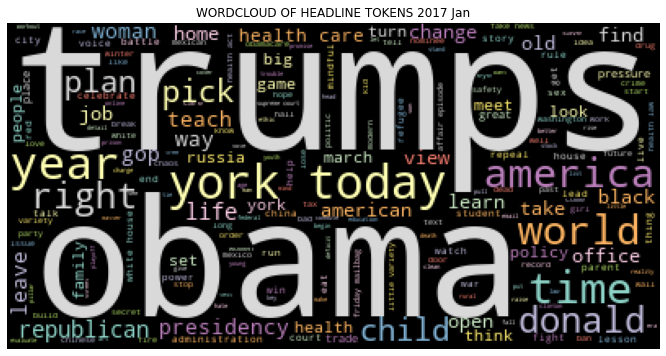

In [20]:
article_2017_jan = get_df(article_clean,'Jan','2017')
generate_wordcloud(article_2017_jan,'headline_tokens','WORDCLOUD OF HEADLINE TOKENS 2017 Jan')

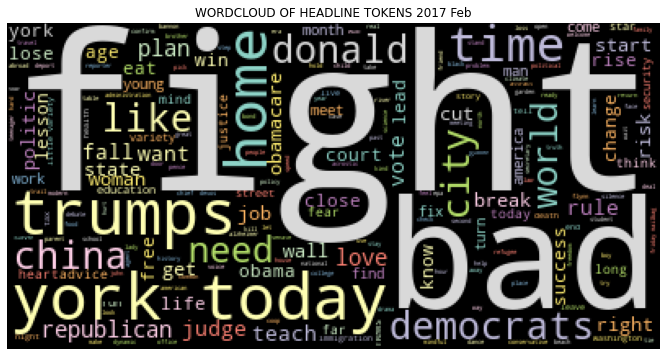

In [21]:
article_2017_feb = get_df(article_clean,'Feb','2017')
generate_wordcloud(article_2017_feb,'headline_tokens','WORDCLOUD OF HEADLINE TOKENS 2017 Feb')

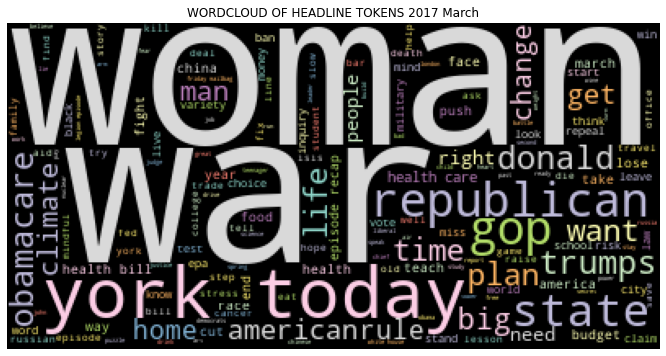

In [22]:
article_2017_march = get_df(article_clean,'March','2017')
generate_wordcloud(article_2017_march,'headline_tokens','WORDCLOUD OF HEADLINE TOKENS 2017 March')

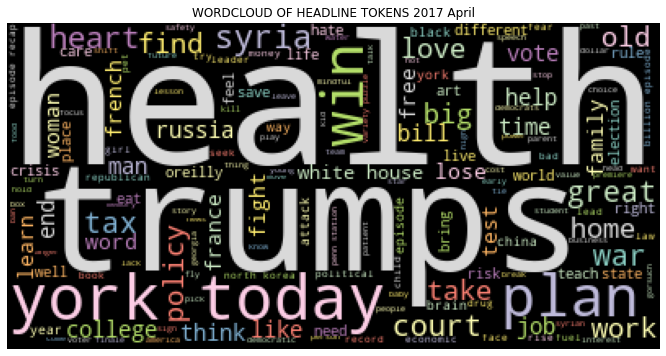

In [23]:
article_2017_april = get_df(article_clean,'April','2017')
generate_wordcloud(article_2017_april,'headline_tokens','WORDCLOUD OF HEADLINE TOKENS 2017 April')

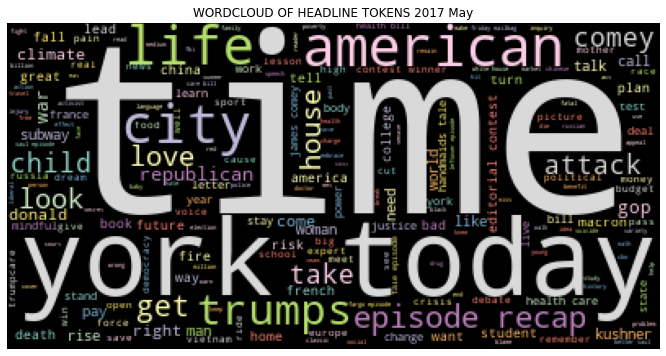

In [24]:
article_2017_may = get_df(article_clean,'May','2017')
generate_wordcloud(article_2017_may,'headline_tokens','WORDCLOUD OF HEADLINE TOKENS 2017 May')

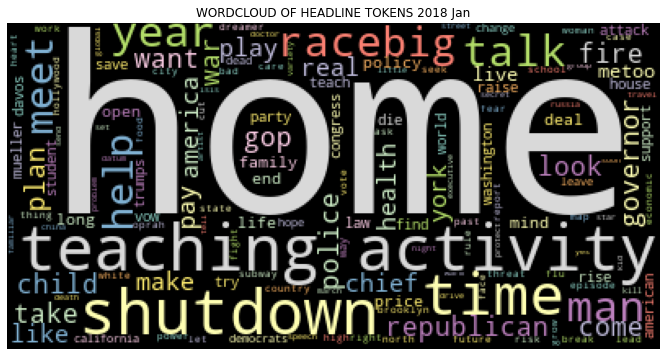

In [25]:
article_2018_jan = get_df(article_clean,'Jan','2018')
generate_wordcloud(article_2018_jan,'headline_tokens','WORDCLOUD OF HEADLINE TOKENS 2018 Jan')

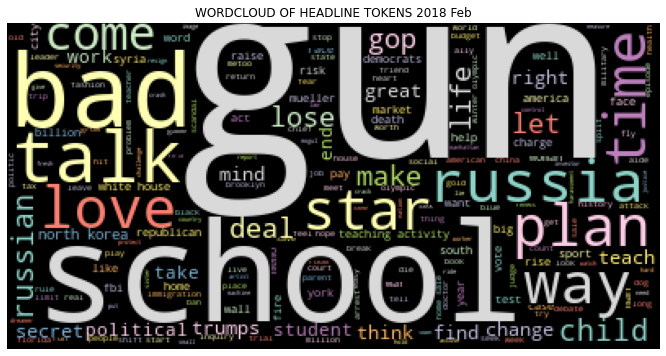

In [26]:
article_2018_feb = get_df(article_clean,'Feb','2018')
generate_wordcloud(article_2018_feb,'headline_tokens','WORDCLOUD OF HEADLINE TOKENS 2018 Feb')

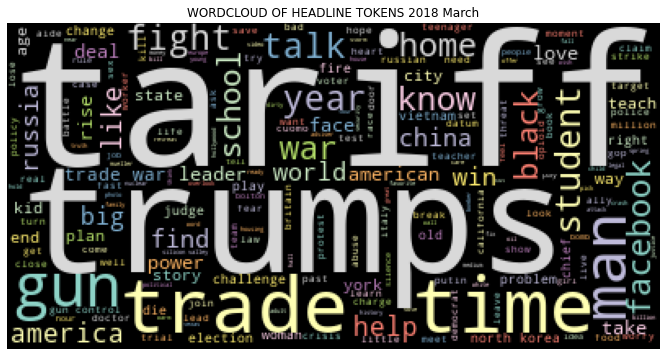

In [27]:
article_2018_march = get_df(article_clean,'March','2018')
generate_wordcloud(article_2018_march,'headline_tokens','WORDCLOUD OF HEADLINE TOKENS 2018 March')

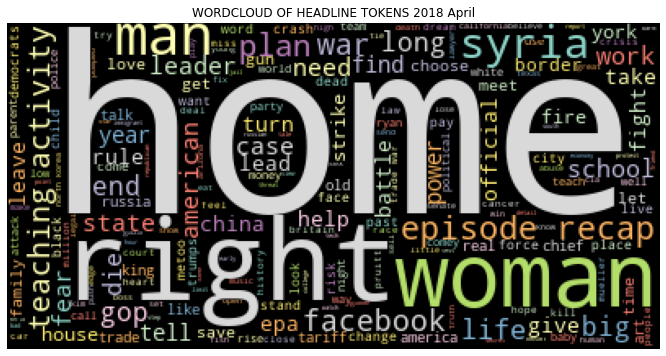

In [28]:
article_2018_april = get_df(article_clean,'April','2018')
generate_wordcloud(article_2018_april,'headline_tokens','WORDCLOUD OF HEADLINE TOKENS 2018 April')

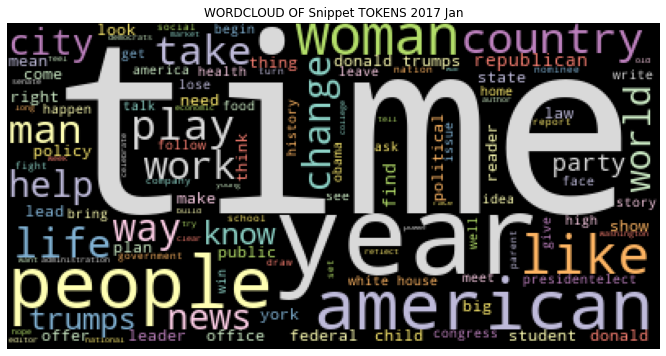

In [29]:

generate_wordcloud(article_2017_jan,'snippet_tokens','WORDCLOUD OF Snippet TOKENS 2017 Jan')

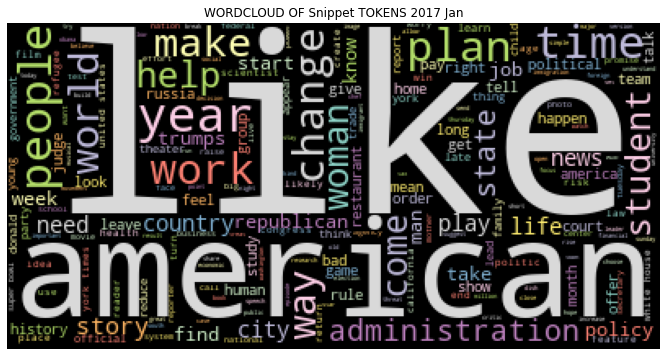

In [30]:

generate_wordcloud(article_2017_feb,'snippet_tokens','WORDCLOUD OF Snippet TOKENS 2017 Jan')

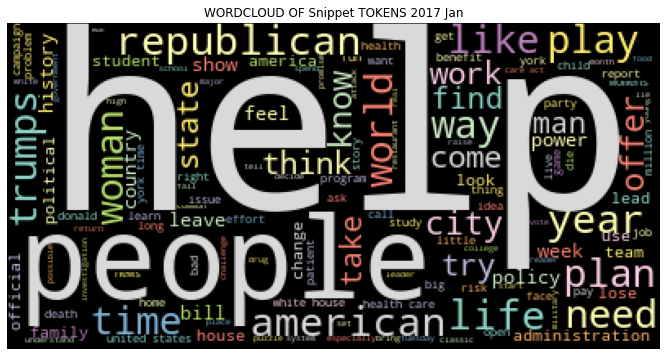

In [31]:

generate_wordcloud(article_2017_march,'snippet_tokens','WORDCLOUD OF Snippet TOKENS 2017 Jan')

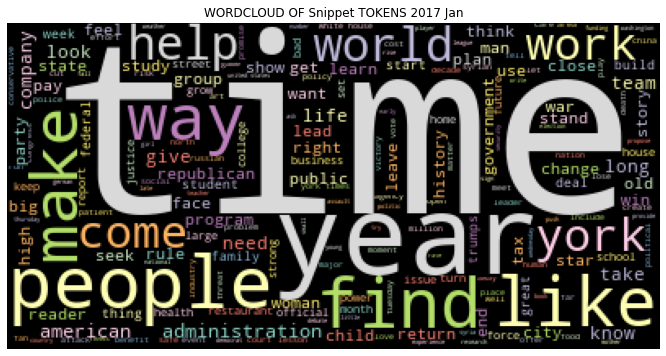

In [32]:

generate_wordcloud(article_2017_april,'snippet_tokens','WORDCLOUD OF Snippet TOKENS 2017 Jan')

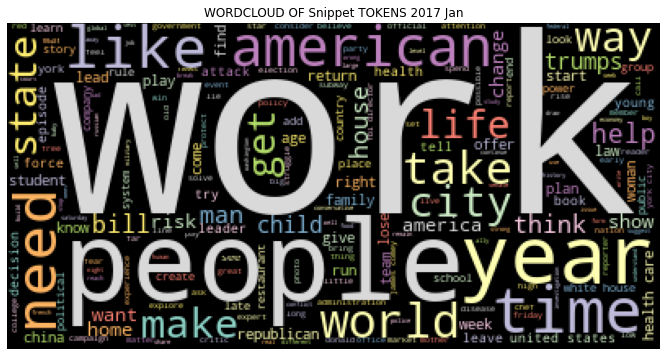

In [33]:

generate_wordcloud(article_2017_may,'snippet_tokens','WORDCLOUD OF Snippet TOKENS 2017 Jan')

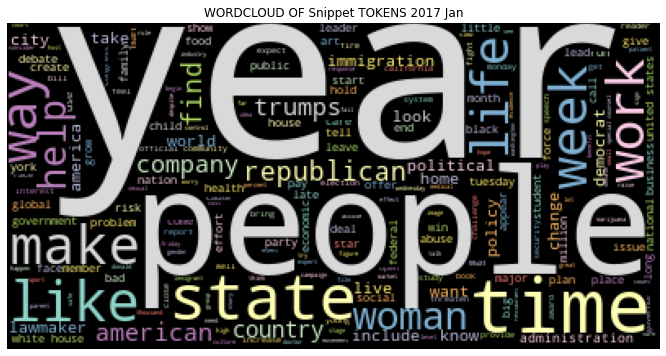

In [34]:

generate_wordcloud(article_2018_jan,'snippet_tokens','WORDCLOUD OF Snippet TOKENS 2017 Jan')

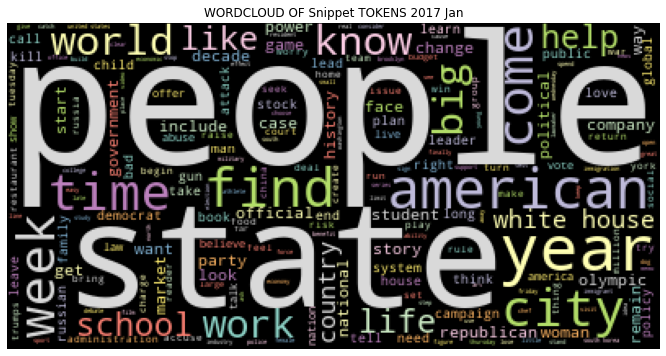

In [35]:

generate_wordcloud(article_2018_feb,'snippet_tokens','WORDCLOUD OF Snippet TOKENS 2017 Jan')

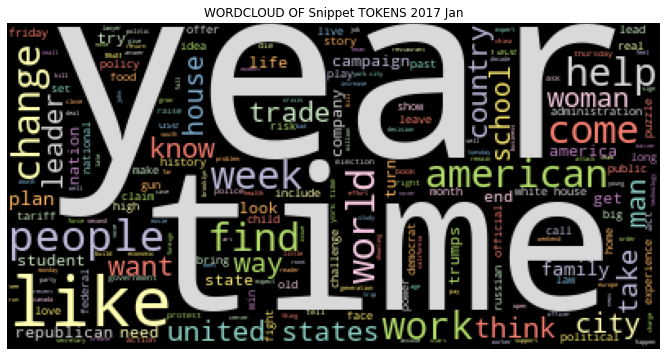

In [36]:

generate_wordcloud(article_2018_march,'snippet_tokens','WORDCLOUD OF Snippet TOKENS 2017 Jan')

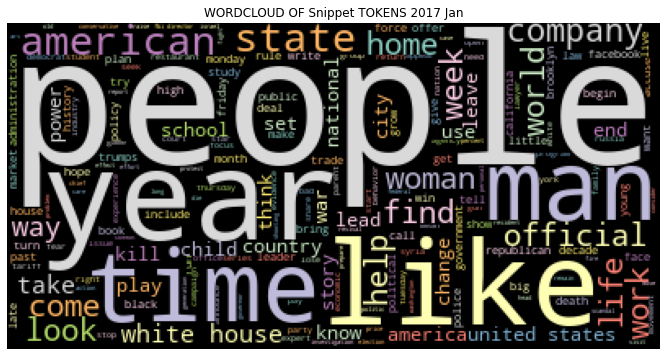

In [37]:

generate_wordcloud(article_2018_april,'snippet_tokens','WORDCLOUD OF Snippet TOKENS 2017 Jan')

In [38]:
!pip install textblob

from textblob import TextBlob


In [39]:

polar = lambda x : TextBlob(x).sentiment.polarity
subject = lambda x : TextBlob(x).sentiment.subjectivity

article_clean['polarity_headlines'] = article_clean['headline'].apply(polar)
article_clean['subjectivity_headlines'] = article_clean['headline'].apply(subject)
article_clean['polarity_snippet'] = article_clean['snippet'].apply(polar)
article_clean['subjectivity_snippet'] = article_clean['snippet'].apply(subject)

In [40]:
article_clean.head()

headline  ... subjectivity_snippet
0     gop leadership poised to topple obamas pillars  ...             0.466667
1  fractured world tested the hope of a young pre...  ...             0.675000
2                               little troublemakers  ...             0.000000
3                  angela merkel russias next target  ...             0.500000
4                      boots for a stranger on a bus  ...             0.000000

[5 rows x 10 columns]

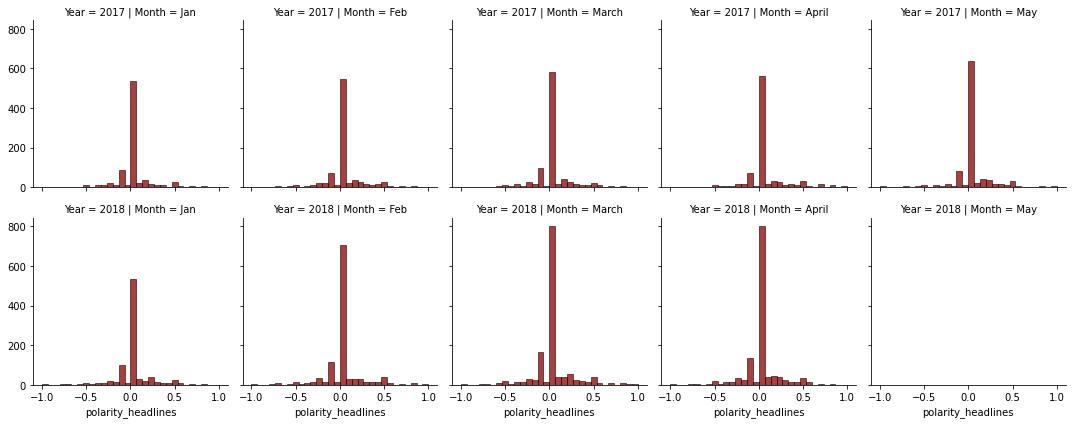

In [41]:
import seaborn as sns
g = sns.FacetGrid(article_clean, col="Month",  row="Year")
g.map_dataframe(sns.histplot, "polarity_headlines",bins=int(30), color = 'darkred')


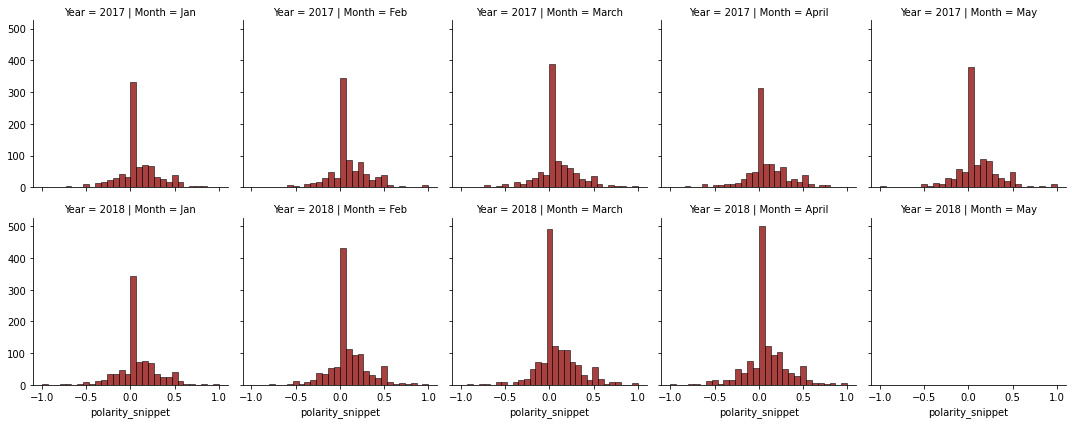

In [42]:
g = sns.FacetGrid(article_clean, col="Month",  row="Year")
g.map_dataframe(sns.histplot, "polarity_snippet",bins=int(30), color = 'darkred')


In [43]:
article_clean

headline  ... subjectivity_snippet
0        gop leadership poised to topple obamas pillars  ...             0.466667
1     fractured world tested the hope of a young pre...  ...             0.675000
2                                  little troublemakers  ...             0.000000
3                     angela merkel russias next target  ...             0.500000
4                         boots for a stranger on a bus  ...             0.000000
...                                                 ...  ...                  ...
1319  this common question reinforces the gender pay...  ...             0.000000
1320                                  anna llama and me  ...             0.000000
1321           gen michael hayden has one regret russia  ...             0.000000
1322                        there is nothin like a tune  ...             1.000000
1323                                            unknown  ...             0.000000

[9335 rows x 10 columns]

In [44]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.decomposition import LatentDirichletAllocation
from gensim import matutils, models
import scipy.sparse

In [45]:
def data_prepare_topic(df,column):
  bigram = gensim.models.Phrases(df[column])
  texts = [bigram[line] for line in df[column]]



  dictionary = Dictionary(texts)
  corpus = [dictionary.doc2bow(text) for text in texts]
  lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

  lsimodel.show_topics(num_topics=5)
  

  lsimodel.show_topics(num_topics=5)
  return corpus, dictionary




In [58]:
def show_topics(df,column):

  no_features = 1000

  tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
  tfidf = tfidf_vectorizer.fit_transform(df[column])
  tfidf_feature_names = tfidf_vectorizer.get_feature_names()

  tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
  tf = tf_vectorizer.fit_transform(df[column])

  tf_feature_names = tf_vectorizer.get_feature_names()

  no_topics = 10

  # Run NMF
  #nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

  # Run LDA
  lda1 = models.LdaModel(corpus = corpus,id2word= dictionary,num_topics=5, passes=200)
  # lda1.show_topics()

  no_top_words = 10
  return lda1,corpus,dictionary

In [47]:
corpus, dictionary = data_prepare_topic(article_2017_jan,'headline_tokens')
lda1,corpus,dictionary = show_topics(article_2017_jan,'headline')
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.087788 -0.104627       1        1  21.881370
1     -0.070067  0.105048       2        1  21.133089
4      0.078797  0.022254       3        1  20.545765
0     -0.015197  0.013166       4        1  18.433312
3      0.094255 -0.035841       5        1  18.006463, topic_info=         Term       Freq      Total Category  logprob  loglift
33    america   7.000000   7.000000  Default  30.0000  30.0000
217     obama  11.000000  11.000000  Default  29.0000  29.0000
9       world   8.000000   8.000000  Default  28.0000  28.0000
11     little   5.000000   5.000000  Default  27.0000  27.0000
27       home   4.000000   4.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
92       rise   1.334795   2.458071   Topic5  -5.9789   1.1038
47       save   1.337079   3.107371   Topic5  -5.9771   0.8711
476     story   1.334685   3.733555   Topic5  -5.9789   0.6858
1450     wall   1.334458   3.084483   Topic5  -5.9791   0.8766
503      drug   1.332976   3.107618   Topic5  -5.9802   0.8680

[296 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
137       5  0.545780        acrostic
1191      1  0.269848  administration
1191      4  0.539695  administration
1191      5  0.269848  administration
25        2  0.533576          affair
...     ...       ...             ...
148       4  0.458375            york
95        1  0.278936      york_today
95        2  0.371914      york_today
95        3  0.371914      york_today
846       5  0.820849            zone

[442 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

In [48]:
corpus, dictionary = data_prepare_topic(article_2017_feb,'headline_tokens')
lda1,corpus,dictionary = show_topics(article_2017_feb,'headline')
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.141932  0.009392       1        1  22.801087
2     -0.000043 -0.100303       2        1  19.738264
4     -0.067487 -0.028956       3        1  19.653731
1     -0.047215  0.001633       4        1  19.608170
0     -0.027186  0.118236       5        1  18.198746, topic_info=          Term      Freq     Total Category  logprob  loglift
118  democrats  7.000000  7.000000  Default  30.0000  30.0000
481       love  6.000000  6.000000  Default  29.0000  29.0000
216    variety  6.000000  6.000000  Default  28.0000  28.0000
214     little  4.000000  4.000000  Default  27.0000  27.0000
28      donald  6.000000  6.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
517       find  1.339333  4.364964   Topic5  -6.0147   0.5224
48     justice  1.339127  3.742209   Topic5  -6.0149   0.6762
184     travel  1.338668  4.346191   Topic5  -6.0152   0.5262
921      human  1.338491  2.480270   Topic5  -6.0153   1.0870
126   national  1.338217  3.099966   Topic5  -6.0155   0.8638

[291 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
63        5  0.817712          abroad
1348      5  0.812575         account
230       3  0.805773        acrostic
217       3  0.805771  administration
130       4  0.802796          advice
...     ...       ...             ...
11        3  0.114734      york_today
11        4  0.229469      york_today
491       1  0.452637           young
491       2  0.226318           young
491       4  0.226318           young

[469 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 2, 1])

In [50]:
corpus, dictionary = data_prepare_topic(article_2017_march,'headline_tokens')
lda1,corpus,dictionary = show_topics(article_2017_march,'headline')
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.085221 -0.111305       1        1  20.725638
2     -0.114932 -0.008868       2        1  20.544104
3     -0.043554 -0.044507       3        1  20.454374
4      0.078053  0.088317       4        1  20.005428
0     -0.004787  0.076364       5        1  18.270456, topic_info=             Term       Freq      Total Category  logprob  loglift
493          life   8.000000   8.000000  Default  30.0000  30.0000
366          plan   8.000000   8.000000  Default  29.0000  29.0000
47          woman  10.000000  10.000000  Default  28.0000  28.0000
556           gop   9.000000   9.000000  Default  27.0000  27.0000
557   health_bill   5.000000   5.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
211         right   1.705692   6.343926   Topic5  -5.8852   0.3864
44          black   1.366052   4.435943   Topic5  -6.1073   0.5221
649     americans   1.365422   4.433136   Topic5  -6.1078   0.5222
1481       safety   1.364316   2.512304   Topic5  -6.1086   1.0893
1345          mix   1.364108   2.512812   Topic5  -6.1087   1.0890

[293 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
82        3  0.522654       abroad
418       3  0.522654     acrostic
1136      5  0.533733  afghanistan
961       1  0.779905          aid
39        4  0.319307          air
...     ...       ...          ...
56        5  0.710876         year
134       1  0.097739   york_today
134       2  0.586437   york_today
134       4  0.293218   york_today
606       1  0.780554        youth

[426 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 5, 1])

In [51]:
corpus, dictionary = data_prepare_topic(article_2017_april,'headline_tokens')
lda1,corpus,dictionary = show_topics(article_2017_april,'headline')
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.061963 -0.071479       1        1  20.927489
4      0.095138  0.081117       2        1  20.602735
3     -0.107794  0.060478       3        1  20.389712
0     -0.037796 -0.092214       4        1  19.127860
2     -0.011511  0.022099       5        1  18.952204, topic_info=           Term      Freq     Total Category  logprob  loglift
677      policy  6.000000  6.000000  Default  30.0000  30.0000
32         plan  8.000000  8.000000  Default  29.0000  29.0000
240       great  6.000000  6.000000  Default  28.0000  28.0000
107      family  5.000000  5.000000  Default  27.0000  27.0000
290        like  5.000000  5.000000  Default  26.0000  26.0000
...         ...       ...       ...      ...      ...      ...
213         win  1.973117  8.133495   Topic5  -5.7277   0.2469
277   political  1.363626  3.746711   Topic5  -6.0972   0.6525
1003     french  1.363365  4.993925   Topic5  -6.0974   0.3650
441       state  1.361765  4.358738   Topic5  -6.0986   0.4998
316         man  1.361304  5.629434   Topic5  -6.0989   0.2437

[285 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
35        1  0.793049    acrostic
545       3  0.532500      airbnb
604       4  0.537614   airstrike
683       4  0.537615        amid
104       3  0.268663       april
...     ...       ...         ...
145       1  0.106566  york_today
145       2  0.319699  york_today
145       3  0.319699  york_today
145       4  0.213133  york_today
145       5  0.106566  york_today

[428 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 1, 3])

In [52]:
corpus, dictionary = data_prepare_topic(article_2017_may,'headline_tokens')
lda1,corpus,dictionary = show_topics(article_2017_may,'headline')
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.011617 -0.140478       1        1  22.135303
1     -0.045678  0.059595       2        1  21.071704
0     -0.108278  0.026428       3        1  20.077293
2      0.053278  0.036652       4        1  18.407709
4      0.112296  0.017802       5        1  18.307991, topic_info=           Term       Freq      Total Category  logprob  loglift
37          get   8.000000   8.000000  Default  30.0000  30.0000
174  york_today  11.000000  11.000000  Default  29.0000  29.0000
165        life   9.000000   9.000000  Default  28.0000  28.0000
532      trumps   9.000000   9.000000  Default  27.0000  27.0000
852        talk   5.000000   5.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
575     kushner   1.366792   5.721640   Topic5  -6.1922   0.2660
821        pain   1.366778   3.810128   Topic5  -6.1922   0.6726
940        well   1.366644   3.794675   Topic5  -6.1923   0.6766
436    remember   1.366304   3.792238   Topic5  -6.1925   0.6770
303        tell   1.366042   5.059203   Topic5  -6.1927   0.3885

[315 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
148       2  0.775719    abortion
2001      5  0.802096      accord
1112      5  0.533561    acrostic
388       2  0.930017      action
71        2  0.517941       adult
...     ...       ...         ...
47        1  0.224298        york
47        3  0.672895        york
47        5  0.224298        york
174       2  0.177820  york_today
174       5  0.800192  york_today

[482 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5])

In [53]:
corpus, dictionary = data_prepare_topic(article_2017_jan,'headline_tokens')
lda1,corpus,dictionary = show_topics(article_2017_jan,'headline')
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.144050  0.023022       1        1  21.209550
0     -0.065077 -0.011999       2        1  20.302432
1     -0.027463  0.098292       3        1  20.217169
3     -0.057705  0.011278       4        1  19.595805
4      0.006194 -0.120593       5        1  18.675044, topic_info=        Term       Freq      Total Category  logprob  loglift
94      year  10.000000  10.000000  Default  30.0000  30.0000
115     news   7.000000   7.000000  Default  29.0000  29.0000
131  variety   5.000000   5.000000  Default  28.0000  28.0000
101    leave   5.000000   5.000000  Default  27.0000  27.0000
61    health   9.000000   9.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
840  college   1.352845   2.483948   Topic5  -6.0019   1.0703
312    stand   1.352753   2.483951   Topic5  -6.0020   1.0703
434   womens   1.352258   2.483965   Topic5  -6.0023   1.0699
119     city   1.352231   3.740792   Topic5  -6.0023   0.6604
38      lead   1.352084   3.732444   Topic5  -6.0024   0.6626

[281 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
137       3  0.533038        acrostic
1191      2  0.267618  administration
1191      3  0.267618  administration
1191      4  0.535237  administration
25        1  0.530234          affair
...     ...       ...             ...
95        1  0.281474      york_today
95        2  0.281474      york_today
95        3  0.281474      york_today
95        4  0.093825      york_today
95        5  0.093825      york_today

[398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])

In [54]:
corpus, dictionary = data_prepare_topic(article_2018_jan,'headline_tokens')
lda1,corpus,dictionary = show_topics(article_2018_jan,'headline')
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.134658  0.051626       1        1  21.854146
4      0.077552  0.098940       2        1  21.596060
1     -0.011358 -0.102153       3        1  20.066574
0      0.038259 -0.052036       4        1  18.249706
3      0.030204  0.003623       5        1  18.233515, topic_info=         Term      Freq     Total Category  logprob  loglift
547      year  7.000000  7.000000  Default  30.0000  30.0000
0        play  5.000000  5.000000  Default  29.0000  29.0000
471      race  6.000000  6.000000  Default  28.0000  28.0000
378  brooklyn  3.000000  3.000000  Default  27.0000  27.0000
959     fight  3.000000  3.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
256      take  1.977841  5.637388   Topic5  -5.7319   0.6545
669      meet  1.982298  6.295164   Topic5  -5.7297   0.5464
286       big  1.977112  6.273238   Topic5  -5.7323   0.5473
786  shutdown  1.980078  8.195205   Topic5  -5.7308   0.2815
546    trumps  1.423959  6.328947   Topic5  -6.0605   0.2102

[297 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
760       5  0.803764   addictive
190       1  0.525043      affair
1065      4  0.540072  affordable
235       1  0.525043         air
562       1  0.401550      amazon
...     ...       ...         ...
427       3  0.229279       world
427       5  0.687836       world
547       1  0.914500        year
202       1  0.196664        york
202       2  0.786656        york

[476 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

In [55]:
corpus, dictionary = data_prepare_topic(article_2018_feb,'headline_tokens')
lda1,corpus,dictionary = show_topics(article_2018_feb,'headline')
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.080620 -0.114012       1        1  21.880814
0      0.092715  0.084530       2        1  21.425487
1     -0.046544  0.060818       3        1  19.650551
4     -0.099443 -0.046164       4        1  19.467946
3     -0.027348  0.014827       5        1  17.575202, topic_info=          Term      Freq     Total Category  logprob  loglift
688      child  8.000000  8.000000  Default  30.0000  30.0000
69         bad  8.000000  8.000000  Default  29.0000  29.0000
127  home_sale  5.000000  5.000000  Default  28.0000  28.0000
256       grow  4.000000  4.000000  Default  27.0000  27.0000
331       mind  7.000000  7.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
763       vote  2.008618  5.730909   Topic5  -5.9748   0.6903
430       case  2.007674  5.798725   Topic5  -5.9753   0.6780
718    million  2.007440  5.103147   Topic5  -5.9754   0.8057
488       deal  2.006332  7.703649   Topic5  -5.9760   0.3933
414       come  2.006109  8.425479   Topic5  -5.9761   0.3036

[326 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
438       3  0.519801  acrostic
201       1  0.765318       act
201       3  0.153064       act
201       5  0.153064       act
1067      4  0.938724       aid
...     ...       ...       ...
249       4  0.387176      year
249       5  0.193588      year
130       1  0.510058      york
130       2  0.170019      york
130       3  0.170019      york

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

In [56]:
corpus, dictionary = data_prepare_topic(article_2018_march,'headline_tokens')
lda1,corpus,dictionary = show_topics(article_2018_march,'headline')
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.145800  0.020566       1        1  23.517036
0     -0.046484  0.024468       2        1  20.297032
2     -0.039956  0.100601       3        1  20.127937
4     -0.002897 -0.113215       4        1  18.927790
1     -0.056463 -0.032419       5        1  17.130206, topic_info=            Term       Freq      Total Category  logprob  loglift
219         talk  10.000000  10.000000  Default  30.0000  30.0000
34        trumps  14.000000  14.000000  Default  29.0000  29.0000
520         know   9.000000   9.000000  Default  28.0000  28.0000
1           real   5.000000   5.000000  Default  27.0000  27.0000
357          big   8.000000   8.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
48   gun_control   2.514409   6.517182   Topic5  -5.9007   0.8119
91           get   2.036347   5.870998   Topic5  -6.1116   0.7055
394         come   2.034101   5.813712   Topic5  -6.1127   0.7142
556         case   2.033576   4.511322   Topic5  -6.1130   0.9675
680        think   2.033317   3.896825   Topic5  -6.1131   1.1138

[330 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
417       4  0.768244  acrostic
931       2  0.506045  actresss
764       1  0.253166   adviser
764       2  0.506332   adviser
764       5  0.253166   adviser
...     ...       ...       ...
147       5  0.095202      year
175       1  0.301366      york
175       2  0.301366      york
175       3  0.150683      york
175       4  0.150683      york

[549 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 2])

In [57]:
corpus, dictionary = data_prepare_topic(article_2018_april,'headline_tokens')
lda1,corpus,dictionary = show_topics(article_2018_april,'headline')
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.065712  0.122788       1        1  21.794145
2     -0.136595  0.029643       2        1  20.807161
4      0.066264 -0.042114       3        1  20.252806
1     -0.012343 -0.021917       4        1  18.679677
3      0.016962 -0.088401       5        1  18.466211, topic_info=                  Term       Freq      Total Category  logprob  loglift
357                man  12.000000  12.000000  Default  30.0000  30.0000
105               need   8.000000   8.000000  Default  29.0000  29.0000
50               right  12.000000  12.000000  Default  28.0000  28.0000
49                home  13.000000  13.000000  Default  27.0000  27.0000
273               dead   8.000000   8.000000  Default  26.0000  26.0000
..                 ...        ...        ...      ...      ...      ...
457  teaching_activity   2.701922  10.403821   Topic5  -5.8828   0.3410
354              woman   2.383187  11.771166   Topic5  -6.0083   0.0920
93               court   2.135736   5.806323   Topic5  -6.1179   0.6891
495             parent   2.065961   5.191789   Topic5  -6.1512   0.7677
213            britain   2.061593   4.538456   Topic5  -6.1533   0.9001

[327 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1030      1  0.502639    accord
679       4  0.772517  acrostic
2172      3  0.510127       act
1488      3  0.510127  activity
880       2  0.911903      aide
...     ...       ...       ...
92        3  0.636680      year
92        4  0.127336      year
403       2  0.307177      york
403       3  0.153589      york
403       4  0.460766      york

[563 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])